<a href="https://colab.research.google.com/github/mikeninerbravog/POC_RecomendationBySimilarity/blob/master/POC_RecomendationBySimilarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**POC - Recomendação por Similaridade**
- Aluno: Marcello S Bastos -
- Bootcamp: BairesDev - Machine Learning Practitioner - Fevereiro de 2025

Este script implementa um sistema de recomendação baseado em similaridade visual de imagens, utilizando a rede ResNet50 para extração de características e FAISS para busca eficiente de imagens semelhantes.

Pode ser encapsulado em uma função ou classe para ser chamado dentro de outros códigos em um e-commerce por exemplo.

Fluxo:
1. O usuário faz upload de um dataset compactado (ZIP) contendo imagens organizadas em pastas por classe.
2. O script extrai o ZIP e constrói um banco de características visuais.
3. O usuário faz upload de uma imagem de consulta.
4. O sistema retorna as imagens mais similares com base em embeddings extraídos da ResNet50.

**Observação Importante:**
Para executar a Prova de Conceito para o bootcamp, usei somente 10 imagens por classe. Em uma situação real, usaria no mínimo 100 imagens por classe.
Então se for executar isso em um ambiente real, aumente a quantidade de objetos em suas classes.

**Comentários no Código:**

Optei em ser o mais verboso possível no comentário do código para facilitar a implantação bem como a avaliação de quem estiver interessado.

In [21]:
# Instala a biblioteca FAISS (Facebook AI Similarity Search), usada para busca eficiente em grandes conjuntos de dados vetoriais
!pip install faiss-cpu

# Importa a biblioteca FAISS, que permite a busca rápida de vetores de alta dimensão
import faiss

# Importa a biblioteca TensorFlow, usada para aprendizado de máquina e redes neurais profundas
import tensorflow as tf

# Importa a biblioteca NumPy, essencial para operações matemáticas e manipulação de arrays
import numpy as np

# Importa a biblioteca Matplotlib, usada para visualização de dados e gráficos
import matplotlib.pyplot as plt

# Importa a biblioteca os, que fornece funções para interação com o sistema operacional
import os

# Importa a biblioteca zipfile, usada para manipulação de arquivos compactados no formato ZIP
import zipfile

# Importa o modelo ResNet50 pré-treinado, útil para extração de características de imagens em aprendizado profundo
from tensorflow.keras.applications import ResNet50

# Importa a função de pré-processamento da ResNet50, que ajusta imagens ao formato esperado pelo modelo
from tensorflow.keras.applications.resnet50 import preprocess_input

# Importa módulos para processamento de imagens, como carregamento e transformação para arrays NumPy
from tensorflow.keras.preprocessing import image

# Importa a biblioteca do Google Colab para manipulação de arquivos dentro do ambiente do Google Colab
from google.colab import files

# Importa a biblioteca PIL (Python Imaging Library), usada para abrir, manipular e salvar imagens em diferentes formatos
from PIL import Image

In [22]:
def setup_model():
    """
    Carrega o modelo ResNet50 pré-treinado com os pesos do ImageNet
    - `weights='imagenet'`: Usa pesos pré-treinados no conjunto de dados ImageNet
    - `include_top=False`: Remove a camada totalmente conectada (FC) final, permitindo usar o modelo como extrator de características
    - `pooling='avg'`: Aplica pooling global médio na saída da última camada convolucional, transformando a saída em um vetor de características
    """
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    # Retorna o modelo carregado, pronto para extrair características de imagens
    return base_model

In [23]:
def extract_features(img_path, model):
    """
    Extrai os embeddings de uma imagem usando ResNet50.
    Carrega a imagem do caminho especificado (`img_path`) e a redimensiona para 224x224 pixels,
    que é o tamanho de entrada esperado pelo modelo ResNet50
    """
    img = image.load_img(img_path, target_size=(224, 224))

    # Converte a imagem carregada em um array NumPy
    img_array = image.img_to_array(img)

    # Expande a dimensão do array para incluir um batch (necessário para entrada no modelo)
    # O modelo espera uma entrada com formato (batch_size, altura, largura, canais)
    img_array = np.expand_dims(img_array, axis=0)


    # Pré-processa a imagem para estar no formato correto para a ResNet50
    # - Normaliza os valores de pixel conforme esperado pelo modelo treinado no ImageNet
    img_array = preprocess_input(img_array)

    # Passa a imagem pelo modelo para extrair os embeddings (features)
    features = model.predict(img_array)

    # Achata o vetor de características para facilitar o uso posterior
    return features.flatten()

In [24]:
def build_feature_database(image_folder, model):
    """Cria um banco de features para as imagens do dataset."""

    # Lista para armazenar os caminhos das imagens processadas
    image_paths = []

    # Lista para armazenar os vetores de features extraídos das imagens
    features = []

    # Percorre recursivamente todas as pastas e arquivos dentro do diretório `image_folder`
    for root, _, files in os.walk(image_folder):
        for file in files:

            # Verifica se o arquivo tem uma extensão de imagem suportada (JPG, PNG, JPEG)
            if file.endswith(('.jpg', '.png', '.jpeg')):

                # Constrói o caminho completo da imagem
                img_path = os.path.join(root, file)
                image_paths.append(img_path)

                # Tenta extrair as features da imagem e armazená-las
                try:
                  features.append(extract_features(img_path, model))
                except Exception as e:
                  print(f"Erro no processamento de imagem {img_path}: {e}")

    # Se nenhuma feature foi extraída, retorna uma mensagem de erro e valores nulos
    if not features:
        print("Não foram extraídos recursos de imagem. Verifique sua pasta de imagem e tipos de arquivos.")
        return [], None

    # Converte a lista de features em um array NumPy de ponto flutuante (float32)
    feature_array = np.array(features, dtype=np.float32)

    # Cria um índice FAISS para busca de similaridade usando a distância L2 (euclidiana)
    faiss_index = faiss.IndexFlatL2(feature_array.shape[1]) # O número de dimensões do vetor de features
    faiss_index.add(feature_array)                          # Adiciona os vetores de features ao índice FAISS

    # Retorna os caminhos das imagens e o índice FAISS construído
    return image_paths, faiss_index

In [25]:
def find_similar(image_path, model, image_paths, faiss_index, top_k=4):
    """Encontra imagens similares no banco de features."""

    # Extrai as features da imagem de consulta (query image)
    query_feature = extract_features(image_path, model)

    # Expande a dimensão do vetor para se adequar ao formato esperado pelo FAISS
    # O FAISS espera uma matriz de entrada com a forma (n_samples, n_features)
    query_feature = np.expand_dims(query_feature, axis=0).astype(np.float32)

    # Realiza a busca no índice FAISS, retornando os `top_k` vizinhos mais próximos
    # - `distances`: lista com as distâncias entre a imagem de consulta e as imagens mais similares
    # - `indices`: lista com os índices das imagens mais similares dentro da base de dados
    distances, indices = faiss_index.search(query_feature, top_k)

    # Retorna os caminhos das imagens correspondentes aos índices encontrados
    return [image_paths[i] for i in indices[0]]

In [26]:
def visualize_results(query_image, similar_images):
    """Exibe a imagem consultada e as imagens mais similares encontradas."""

    # Define o layout da figura com subplots em uma única linha
    # O número total de colunas será o número de imagens similares + 1 (para a imagem de entrada)
    fig, axes = plt.subplots(1, len(similar_images) + 1, figsize=(15, 5))

    # Exibe a imagem de entrada (consulta)
    axes[0].imshow(Image.open(query_image))   # Abre a imagem e a exibe
    axes[0].set_title("Imagem de Entrada")    # Define o título da imagem
    axes[0].axis("off")                       # Remove os eixos para uma visualização limpa

    # Exibe as imagens similares encontradas
    for i, img_path in enumerate(similar_images):
        axes[i + 1].imshow(Image.open(img_path))  # Abre e exibe a imagem similar
        axes[i + 1].set_title(f"Similar {i + 1}") # Define o título indicando a ordem da similaridade
        axes[i + 1].axis("off")                   # Remove os eixos para melhor apresentação

    # Mostra a figura com todas as imagens
    plt.show()

In [27]:
def extract_zip():
    """Extrai o conteúdo de um arquivo ZIP enviado pelo usuário."""

    # Permite que o usuário faça o upload de um arquivo ZIP
    uploaded = files.upload()

    # Obtém o nome do arquivo ZIP enviado pelo usuário
    zip_path = list(uploaded.keys())[0]

    # Define o diretório de extração dos arquivos contidos no ZIP
    extract_to = "dataset_tools"

    # Abre o arquivo ZIP e extrai todo o seu conteúdo para a pasta especificada
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Exibe uma mensagem informando onde os arquivos foram extraídos
    print(f"Arquivos extraídos para: {extract_to}")

    # Retorna o caminho onde os arquivos foram extraídos
    return extract_to

In [28]:
# Executar configuração do modelo
model = setup_model()

# Upload do dataset compactado pelo usuário
print("Faça o upload do arquivo ZIP contendo as imagens organizadas em pastas por classe.")
dataset_folder = extract_zip()

# Criar banco de features
image_paths, faiss_index = build_feature_database(dataset_folder, model)

Faça o upload do arquivo ZIP contendo as imagens organizadas em pastas por classe.


Saving tools.zip to tools (1).zip
Arquivos extraídos para: dataset_tools
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms

Agora, faça o upload de uma imagem para buscar similares.


Saving 81ILCwxf-9L.jpg to 81ILCwxf-9L (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


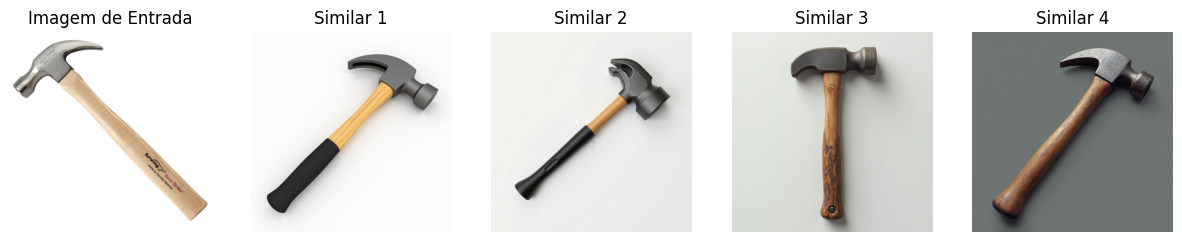

In [29]:
# Verifica se o banco de features foi criado corretamente
while faiss_index is None:
    print("Erro: O banco de features não foi criado. Faça o upload de um arquivo ZIP válido contendo imagens organizadas.")

    # Solicita novamente o upload de um arquivo ZIP com imagens válidas
    dataset_folder = extract_zip()

    # Reconstrói o banco de features
    image_paths, faiss_index = build_feature_database(dataset_folder, model)

# Upload de imagem para busca de similares
print("Agora, faça o upload de uma imagem para buscar similares.")
uploaded = files.upload()
query_image_path = list(uploaded.keys())[0]

# Buscar imagens similares
similar_images = find_similar(query_image_path, model, image_paths, faiss_index)

# Exibir resultados
visualize_results(query_image_path, similar_images)